Step 6: Non-stationary demand curves

In [1]:
#uncertain graph weights (different click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates

In [204]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.Learner_Environment import *
from Algorithms.SWTS_Learner import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.Estimate_click_probabilities import *
from Algorithms.SW_UCB_Learner import SW_UCB
from Algorithms.CD_UCB_Learner import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce(binary_features=1)
E.set_lambda(0.5)
E.set_products(products)

#Ecommerce graph weights are uncertain, for each user they are different, but the slots are fixed by the Ecommerce
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])

n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        #if (d==30):
        #    User0.setprice()
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt1 = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt1) # optimal configuration: the best combination of arms

_______________________________________________
Conversion rates
[[0.82281803 0.41543695 0.09907931 0.00147872]
 [0.84708007 0.46205925 0.06466399 0.00056234]
 [0.94792427 0.55143517 0.10586905 0.00301717]
 [0.95991028 0.52367856 0.17054951 0.02348537]
 [0.99686741 0.70570212 0.29584791 0.02095199]]
_______________________________________________
Expected rewards per arm
[[ 6.57979427  4.97672674  1.57684443  0.028553  ]
 [ 5.07936398  3.97504378  0.77338377  0.0067222 ]
 [22.17308214 17.85392305  4.37491827  0.14203445]
 [44.92604016 32.30993653 12.03481773  1.87238282]
 [39.87821237 35.27405444 17.76345454  1.45289268]]
_______________________________________________
Expected units sold per arm
[[2.  2.  2.  2. ]
 [1.  1.  1.  0.9]
 [3.  3.  3.  3. ]
 [3.  3.  3.  3. ]
 [1.  1.  1.  1. ]]
_______________________________________________
Best configuration [0. 0. 0. 0. 0.]
Optimal cumulative expected reward per round
118.61493051873624


In [206]:
opt1

118.61493051873624

In [207]:
np.std(conv_rates_per_experiment)

0.36049273613026844

The initial optimal cumulative expected reward per round is 118.54


In [208]:
#Ecommerce graph weights are uncertain, for each user they are different, but the slots are fixed by the Ecommerce
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []
change = [np.array([1.15,0.95,1.2,0.9,1]) for _ in range(3) ]

for e in range(num_experiments):
    #reset_users_reserv_prices() viene chiamato quando crei env
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    print("Original reservation prices:")
    print(User0.avg_reservation_price)
    print(User1.avg_reservation_price)
    print(User2.avg_reservation_price)
    env.abrupt_change([0,1,2],change)

    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        #if (d==30):
        #    User0.setprice()
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt2 = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#

print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt2) # optimal configuration: the best combination of arms

Original reservation prices:
[ 23  34  31  46 104]
[21 32 29 44 95]
[21 31 28 42 87]
--------------------------------
--------------------------------
Abrupt change
--------------------------------
--------------------------------
class User 0 has changed: its new average reservation price is [ 26.45  32.3   37.2   41.4  104.  ]
class User 1 has changed: its new average reservation price is [24.15 30.4  34.8  39.6  95.  ]
class User 2 has changed: its new average reservation price is [24.15 29.45 33.6  37.8  87.  ]
Original reservation prices:
[ 23  34  31  46 104]
[21 32 29 44 95]
[21 31 28 42 87]
--------------------------------
--------------------------------
Abrupt change
--------------------------------
--------------------------------
class User 0 has changed: its new average reservation price is [ 26.45  32.3   37.2   41.4  104.  ]
class User 1 has changed: its new average reservation price is [24.15 30.4  34.8  39.6  95.  ]
class User 2 has changed: its new average reservation

## SW-UCB

### Simulation in a static environment

In [209]:
#Comparison between SW-UCB and UCB

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 5

window_size = 90

sw_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

sw_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    sw_UCB_learner = SW_UCB(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = sw_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        sw_UCB_learner.update(pulled_arm, reward)

    sw_ucb_rewards_per_experiment.append(sw_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    sw_ucb_pulls_per_arm_per_experiment.append(sw_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


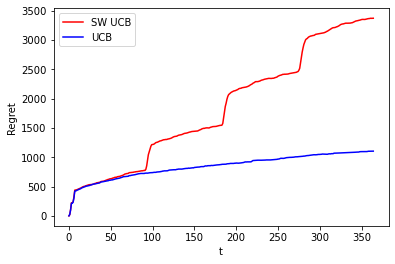

In [210]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt1 - sw_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt1 - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["SW UCB","UCB"])
plt.show()

Come previsto, SW UCB si comporta peggio di UCB (in un AMBIENTE STATICO).

In [211]:
#Comparison between SW-UCB and UCB in a dynamic environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 5

days_of_change = [100,275] #April 10 and October 2

window_size = 100

sw_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

sw_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    sw_UCB_learner = SW_UCB(n_arms, window_size)

    for d in range(n_days):
        #for day_of_change in days_of_change:
        if d==100: # day_of_change:
            env.abrupt_change([0,1,2],change)
        if d==275:
            reset_users_reserv_prices()

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = sw_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        sw_UCB_learner.update(pulled_arm, reward)

    sw_ucb_rewards_per_experiment.append(sw_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    sw_ucb_pulls_per_arm_per_experiment.append(sw_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lucamainini/opt/anaconda3/envs/math_environment/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--------------------------------
--------------------------------
Abrupt change
--------------------------------
--------------------------------
class User 0 has changed: its new average reservation price is [ 26.45  32.3   37.2   41.4  104.  ]
class User 1 has changed: its new average reservation price is [24.15 30.4  34.8  39.6  95.  ]
class User 2 has changed: its new average reservation price is [24.15 29.45 33.6  37.8  87.  ]
--------------------------------
--------------------------------
Abrupt change
--------------------------------
--------------------------------
class User 0 has changed: its new average reservation price is [ 26.45  32.3   37.2   41.4  104.  ]
class User 1 has changed: its new average reservation price is [24.15 30.4  34.8  39.6  95.  ]
class User 2 has changed: its new average reservation price is [24.15 29.45 33.6  37.8  87.  ]
--------------------------------
--------------------------------
Abrupt change
--------------------------------
---------------

In [10]:
days_of_change[0],days_of_change[1]

(100, 275)

In [11]:
sw_ucb_rewards = np.mean(sw_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

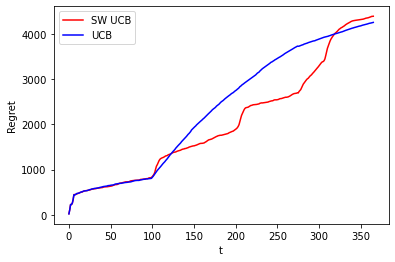

In [12]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
part1 = np.cumsum(opt1-sw_ucb_rewards[0:days_of_change[0]])
temp = part1[days_of_change[0]-2] +np.cumsum(opt2-sw_ucb_rewards[(days_of_change[0]-1):days_of_change[1]])
part2 = np.concatenate((part1,temp))
part3 = part2[days_of_change[1]-2] +np.cumsum(opt1-sw_ucb_rewards[(days_of_change[1]-1):])
plot1 = np.concatenate((part2,part3))
plt.plot(plot1, 'r')

part1 = np.cumsum(opt1-ucb_rewards[1:days_of_change[0]])
temp = part1[days_of_change[0]-2] +np.cumsum(opt2-ucb_rewards[(days_of_change[0]-1):days_of_change[1]])
part2 = np.concatenate((part1,temp))
part3 = part2[days_of_change[1]-2] +np.cumsum(opt1-ucb_rewards[(days_of_change[1]-1):])
plot2 = np.concatenate((part2,part3))
plt.plot(plot2, 'b')



plt.legend(["SW UCB","UCB"])
plt.show()

Questa volta SW-UCB si comporta meglio!

## Change-detection UCB (CUSUM based - paper version)

day  0
pulled arm: [0 0 0 0 0]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
day  1
pulled arm: [1 1 1 1 1]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
day  2
pulled arm: [2 2 2 2 2]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
day  3
pulled arm: [3 3 3 3 3]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
day  4
pulled arm: [0 0 0 0 0]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running C

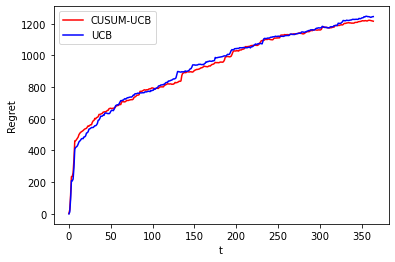

In [149]:
#Comparison between CU-SUM UCB and UCB
# static environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 2
window_size = 100

cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms,M=20,eps=0.3, h=7)

    for d in range(n_days):
        print('day ', d)
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        #print(pulled_arm)
        reward = env.round(pulled_arm)
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm,)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt1 - cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt1 - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CUSUM-UCB", "UCB"])
plt.show()

In [150]:
change = [np.array([1.15,0.95,1.2,0.9,1]) for _ in range(3) ]

In [190]:
#Comparison between CUSUM-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

days_of_change = [100,275]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms, M=15, eps=0.1, h=9)

    for d in range(n_days):
        print('--------day--------', d)
        if d==100: # day_of_change:
            env.abrupt_change([0,1,2],change)
        if d==275:
            reset_users_reserv_prices()
        # for day_of_change in days_of_change:
        #     if d==day_of_change:
        #         env.abrupt_change([0,1,2],change)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm)
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

--------day-------- 0
pulled arm: [0 0 0 0 0]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
--------day-------- 1
pulled arm: [1 1 1 1 1]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
--------day-------- 2
pulled arm: [2 2 2 2 2]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
--------day-------- 3
pulled arm: [3 3 3 3 3]
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
running CUSUM algorithm
troppo presto
--------day-------- 4
pulled arm: [0 0 0 0 0]
running CU

In [191]:
for p in range(5):
    for arm in range(4):
        print('product',p, 'arm',arm)
        print(cd_UCB_learner.detections[p][arm])

product 0 arm 0
[112, 305]
product 0 arm 1
[279]
product 0 arm 2
[]
product 0 arm 3
[]
product 1 arm 0
[]
product 1 arm 1
[]
product 1 arm 2
[]
product 1 arm 3
[]
product 2 arm 0
[]
product 2 arm 1
[107]
product 2 arm 2
[276]
product 2 arm 3
[]
product 3 arm 0
[101, 277]
product 3 arm 1
[]
product 3 arm 2
[]
product 3 arm 3
[]
product 4 arm 0
[]
product 4 arm 1
[]
product 4 arm 2
[]
product 4 arm 3
[]


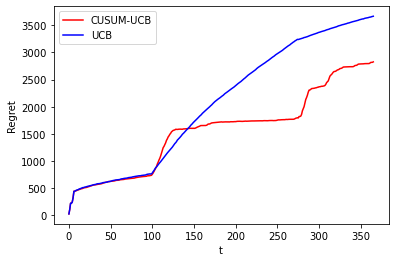

In [192]:
cd_ucb_rewards = np.mean(cd_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
part1 = np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]])
temp = part1[days_of_change[0]-2] +np.cumsum(opt2-cd_ucb_rewards[(days_of_change[0]-1):days_of_change[1]])
part2 = np.concatenate((part1,temp))
part3 = part2[days_of_change[1]-2] +np.cumsum(opt1-cd_ucb_rewards[(days_of_change[1]-1):])
plot1 = np.concatenate((part2,part3))
plt.plot(plot1, 'r')

part1 = np.cumsum(opt1-ucb_rewards[1:days_of_change[0]])
temp = part1[days_of_change[0]-2] +np.cumsum(opt2-ucb_rewards[(days_of_change[0]-1):days_of_change[1]])
part2 = np.concatenate((part1,temp))
part3 = part2[days_of_change[1]-2] +np.cumsum(opt1-ucb_rewards[(days_of_change[1]-1):])
plot2 = np.concatenate((part2,part3))
plt.plot(plot2, 'b')

plt.legend(["CUSUM-UCB","UCB"])
plt.show()

Text(0.5, 1.0, 'product 0 - down')

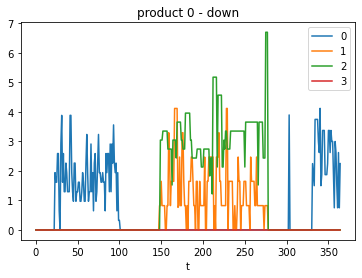

In [193]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[0][arm])
plt.legend([0,1,2,3])
plt.title("product 0 - down")
#change of +15%

Text(0.5, 1.0, 'product 0 - up')

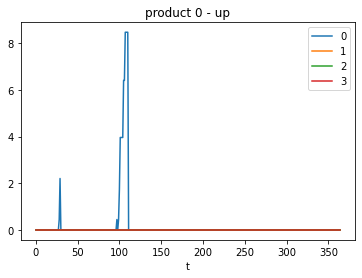

In [194]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[0][arm])
plt.legend([0,1,2,3])
plt.title("product 0 - up")
#change of +15%

Text(0.5, 1.0, 'product 1 - down')

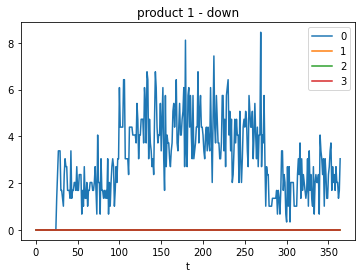

In [195]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[1][arm])
plt.legend([0,1,2,3])
plt.title("product 1 - down")
#change of -5%

Text(0.5, 1.0, 'product 1 - up')

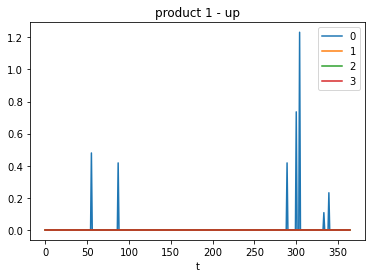

In [196]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[1][arm])
plt.legend([0,1,2,3])
plt.title("product 1 - up")
#change of -5%

Text(0.5, 1.0, 'product 2 - down')

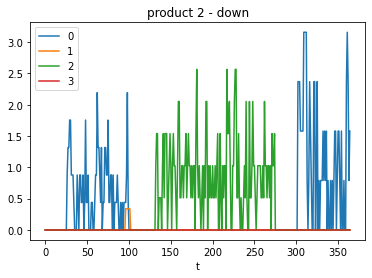

In [197]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[2][arm])
plt.legend([0,1,2,3])
plt.title("product 2 - down")
#change of +20%

Text(0.5, 1.0, 'product 2 - up')

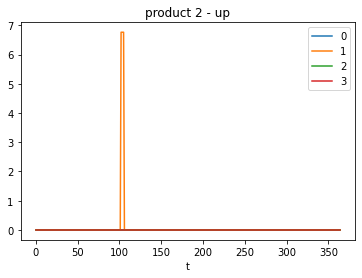

In [198]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[2][arm])
plt.legend([0,1,2,3])
plt.title("product 2 - up")
#change of +20%

Text(0.5, 1.0, 'product 3 - down')

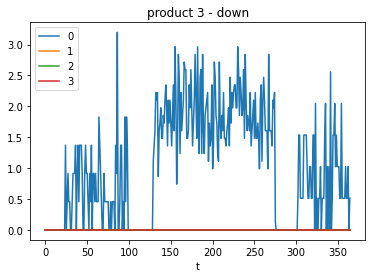

In [199]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[3][arm])
plt.legend([0,1,2,3])
plt.title("product 3 - down")
#change of -10%

Text(0.5, 1.0, 'product 3 - up')

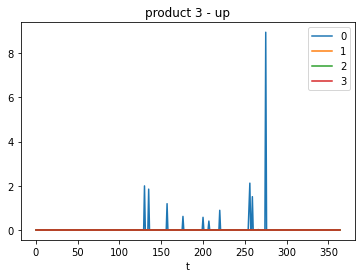

In [200]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[3][arm])
plt.legend([0,1,2,3])
plt.title("product 3 - up")
#change of -10%

Text(0.5, 1.0, 'product 4 - down')

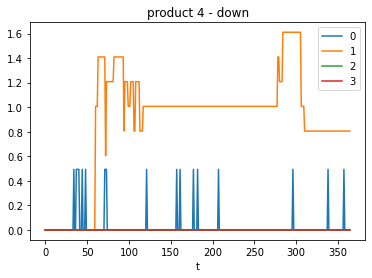

In [201]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[4][arm])
plt.legend([0,1,2,3])
plt.title("product 4 - down")
## no change

Text(0.5, 1.0, 'product 4 - up')

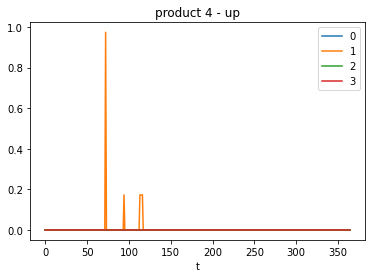

In [202]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[4][arm])
plt.legend([0,1,2,3])
plt.title("product 4 - up")
## no change